In [12]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Dot, Activation, Concatenate

In [ ]:
latent_dim = 256
vocab_size_input = 10000
vocab_size_target = 10000
max_len_input = 20
max_len_output = 20

# Encoder input
encoder_inputs = Input(shape=(None,), name='encoder_input')
enc_emb = Embedding(vocab_size_input, latent_dim)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name='encoder_lstm')
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

In [ ]:
# Decoder input
decoder_inputs = Input(shape=(None,), name='decoder_input')
dec_emb = Embedding(vocab_size_target, latent_dim)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm')
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Attention mechanism
attention = Dot(axes=[2, 2], name='attention_dot')([decoder_outputs, encoder_outputs])  # shape: (batch, dec_len, enc_len)
attention = Activation('softmax', name='attention_weights')(attention)

# Context vector
context = Dot(axes=[2,1], name='context_vector')([attention, encoder_outputs])
decoder_combined_context = Concatenate(axis=-1, name='concat_layer')([context, decoder_outputs])

# Output layer
output = Dense(vocab_size_target, activation='softmax', name='dense_output')(decoder_combined_context)

# Final model
model = Model([encoder_inputs, decoder_inputs], output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 256) │  2,560,000 │ encoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 256) │  2,560,000 │ decoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, None,     │    525,312 │ embedding[0][0]   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, None,     │    525,312 │ embedding_1[0][0… │
│                     │ 256), (None,      │            │ encoder_lstm[0][… │
│                     │ 256), (None,      │            │ encoder_lstm[0][… │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_dot (Dot) │ (None, None,      │          0 │ decoder_lstm[0][… │
│                     │ None)             │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weights   │ (None, None,      │          0 │ attention_dot[0]… │
│ (Activation)        │ None)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_vector      │ (None, None, 256) │          0 │ attention_weight… │
│ (Dot)               │                   │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_layer        │ (None, None, 512) │          0 │ context_vector[0… │
│ (Concatenate)       │                   │            │ decoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_output        │ (None, None,      │  5,130,000 │ concat_layer[0][… │
│ (Dense)             │ 10000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,300,624 (43.11 MB)

 Trainable params: 11,300,624 (43.11 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
num_samples = 1000
input_tensor = np.random.randint(0, vocab_size_input, size=(num_samples, max_len_input))
target_tensor_input = np.random.randint(0, vocab_size_target, size=(num_samples, max_len_output))
target_tensor_output = np.random.randint(0, vocab_size_target, size=(num_samples, max_len_output, 1))

target_tensor_output = np.squeeze(target_tensor_output, axis=-1)

In [ ]:
history = model.fit(
    [input_tensor, target_tensor_input],
    target_tensor_output,
    batch_size=64,
    epochs=10,
    validation_split=0.2
)

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - loss: 9.2104 - val_loss: 9.2101
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - loss: 9.1910 - val_loss: 9.4149
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - loss: 8.9690 - val_loss: 9.3023
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - loss: 8.8423 - val_loss: 9.8190
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - loss: 8.6831 - val_loss: 10.0144
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - loss: 8.5722 - val_loss: 10.1331
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - loss: 8.4559 - val_loss: 10.4037
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - loss: 8.3551 - val_loss: 10.5295
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - loss: 8.2919 - val_loss: 10.6550
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - loss: 8.1664 - val_loss: 10.7830


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


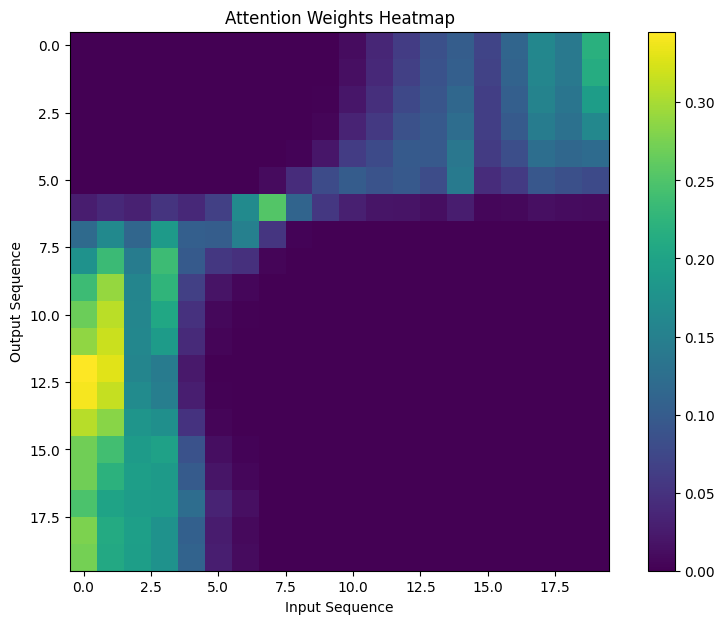

In [ ]:
attention_layer_model = Model(inputs=model.input, outputs=model.get_layer('attention_weights').output)

input_seq = input_tensor[0:1]
decoder_seq = target_tensor_input[0:1]
attention_weights = attention_layer_model.predict([input_seq, decoder_seq])

# Visualize as heatmap
plt.figure(figsize=(10, 7))
plt.imshow(attention_weights[0], cmap='viridis')
plt.xlabel('Input Sequence')
plt.ylabel('Output Sequence')
plt.colorbar()
plt.title('Attention Weights Heatmap')
plt.show()

In [18]:
import matplotlib.pyplot as plt

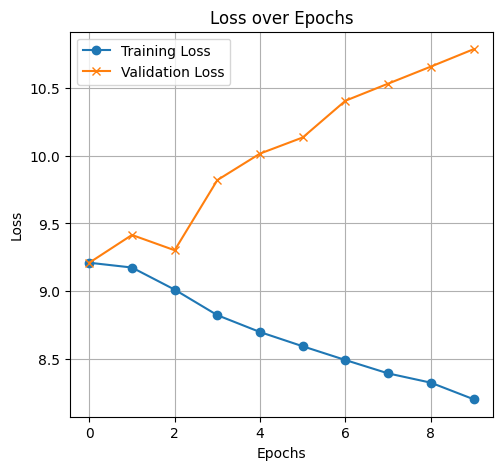

In [14]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='x')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
